In [2]:
import nltk
import random
import re
import string

from nltk import FreqDist
from nltk import classify
from nltk import NaiveBayesClassifier
from nltk.corpus import twitter_samples
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

In [3]:
def remove_noise(tweet_tokens, stop_words = ()):
    '''Remove @ mentions, hyperlinks, punctuation, and stop words'''

    cleaned_tokens = []

    for token, tag in pos_tag(tweet_tokens):
        # Remove Hyperlinks
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        # Remove twitter handles
        token = re.sub("(@[A-Za-z0-9_]+)","", token)
        
        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        # Normalize sentence
        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)

        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            # Get lowercase
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

In [4]:
stop_words = stopwords.words('english')

positive_tweet_tokens = twitter_samples.tokenized('positive_tweets.json')
negative_tweet_tokens = twitter_samples.tokenized('negative_tweets.json')

positive_cleaned_tokens_list = []
negative_cleaned_tokens_list = []

for tokens in positive_tweet_tokens:
    positive_cleaned_tokens_list.append(remove_noise(tokens, stop_words))

for tokens in negative_tweet_tokens:
    negative_cleaned_tokens_list.append(remove_noise(tokens, stop_words))

In [5]:
def get_tweets_for_model(cleaned_tokens_list):
    for tweet_tokens in cleaned_tokens_list:
        yield dict([token, True] for token in tweet_tokens)

positive_tokens_for_model = get_tweets_for_model(positive_cleaned_tokens_list)
negative_tokens_for_model = get_tweets_for_model(negative_cleaned_tokens_list)

In [6]:
# To randomly shuffle the test data, need to convert to list
positive_dataset = [(tweet_dict, "Positive")
                     for tweet_dict in positive_tokens_for_model]

negative_dataset = [(tweet_dict, "Negative")
                     for tweet_dict in negative_tokens_for_model]

dataset = positive_dataset + negative_dataset

random.shuffle(dataset)

# 70-30 split
train_data = dataset[:7000]
test_data = dataset[7000:]

In [7]:
classifier = NaiveBayesClassifier.train(train_data)
 
classify.accuracy(classifier, test_data)

0.9936666666666667

In [8]:
#custom_tweet = "Amazon is an amazing website"
custom_tweet = "Amazon isn't what it looks like"

In [9]:
classifier.classify(dict([token, True] 
                    for token in remove_noise(word_tokenize(custom_tweet))))

'Negative'

In [10]:
import pickle
pickle.dump(classifier, open('model.pickle', 'wb'))

In [11]:
from nltk.metrics import *

In [12]:
negative_tweets = twitter_samples.strings('negative_tweets.json')
positive_tweets = twitter_samples.strings('positive_tweets.json')

In [13]:
pp, pn = 0, 0
false_positive = []
for tweet in positive_tweets:
    x = classifier.classify(dict([token, True] 
                    for token in remove_noise(word_tokenize(tweet))))
    if x == 'Negative':
        pn += 1
        false_positive.append(tweet)
    else:
        pp += 1

In [14]:
print(pp, pn)

4101 899


In [15]:
np, nn = 0, 0
false_negative = []
for tweet in negative_tweets:
    x = classifier.classify(dict([token, True] 
                    for token in remove_noise(word_tokenize(tweet))))
    if x == 'Negative':
        nn += 1
    else:
        np += 1
        false_negative.append(tweet)

In [16]:
print(np, nn)

722 4278


In [17]:
#print(nltk.ConfusionMatrix(positive_dataset, positive_tweets))

In [18]:
documents = ([(t, "Positive") for t in twitter_samples.strings("positive_tweets.json")] + 
             [(t, "Negative") for t in twitter_samples.strings("negative_tweets.json")])

In [ ]:
# out of 5000 positive tweets, 

# 4225 were correctly classified as positive
# 775 were wrongly classified as negative

# out of 5000 negative tweets,

# 4131 were correctly classified as negative
# 869 were wrongly classified as positive


'''

                 Actual Class
                 _____________
                | pos  |  neg |
                |______|______|
Predicted   pos | 4225 | 869  |
class           |______|______|
            neg | 775  | 4131 |
                |______|______|
    
'''

In [19]:
from sklearn.metrics import *

In [20]:
ref = [test_data[i][1] for i in range(len(test_data))]

In [ ]:
#ref = ['pos', 'pos', 'neg', 'pos', 'neg', 'pos', 'neg', 'neg', 'pos', 'pos']
#test = ['pos', 'neg', 'pos', 'pos', 'pos', 'pos', 'neg', 'pos', 'neg', 'pos']

In [21]:
test = []
for tweet in test_data:
    test.append(classifier.classify(tweet[0]))

In [22]:
nltk.ConfusionMatrix(ref, test)

<ConfusionMatrix: 2981/3000 correct>

In [23]:
cm=confusion_matrix(ref, test)

In [32]:
def my_confusion_matrix(ref, test):
    tp, tn, fp, fn = 0, 0, 0, 0
    
    for i in range(len(test)):
        if ref[i] == test[i]:
            if ref[i] == 'Positive':
                tp += 1
            else:
                tn += 1
        else:
            if ref[i] == 'Negative':
                fp += 1
            else:
                fn += 1
    return (tp, tn, fp, fn)

In [33]:
my_confusion_matrix(ref, test)

(1496, 1485, 5, 14)

In [26]:
import matplotlib.pyplot as plt 

In [27]:
from sklearn.metrics import ConfusionMatrixDisplay

In [28]:
display_labels = ['pos', 'neg']

In [29]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classifier.labels())


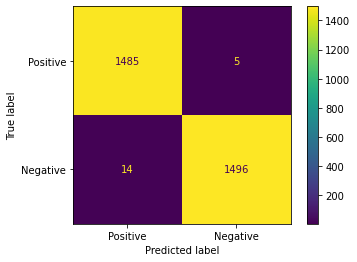

In [30]:
disp = disp.plot()